# 导师制名企实训班商业智能方向 004期 Lesson 21

### Thinking 1: 电商定向广告和搜索广告有怎样的区别，算法模型是否有差别

定向广告是给不同的人推荐不同的页面，是一种用户被动的信息获取，推荐系统通过分析用户历史行为信息对用户进行用户画像，为用户推送定制的内容。 算法模型上主要利用用户的历史行为信息进行推荐，如LR模型、MLR模型、DNN模型、DIN、DIEN、DSIN。  
搜索广告是基于用户输入的检索序列在广告库中进行信息搜索匹配得到要推送的广告，对于用户来说是主动的信息获取过程。算法模型上主要依靠用户输入的检索信息。

### Thinking 2: 定向广告都有哪些常见的使用模型，包括Attention机制模型

* DIN：深度兴趣网络，主要使用Attention机制筛选用户历史行为中如目标商品相关的信息，减少无关信息的干扰。
* DIEN：深度兴趣演化网络，通过引入GRU来学习用户行为中的顺序信息，建模用户行为的演进过程。
* DSIN：深度会话兴趣网络，通过对Session内使用自注意力机制学习Session的表达，使用Attention机制进行相关信息筛选，最后使用Bi-LSTM进行兴趣演化的建模。

### Thinking 3: DIN中的Attention机制思想和原理是怎样的

DIN中Attention机制的思想是模拟人类视觉上对于不同位置的注意力分布不同的机制，人类会在观察物体时优先关注重要的部分。在DIN中利用Attention机制将于Candidate Ad相关的商品权重调大，与其无关的商品权重调小。Attention Unit模块通过计算用户行为Embedding和候选广告Embedding两个向量之间的相似度来得到Activation Weight，具体实现上考虑了两个输入向量和两个向量的外积，将三个向量拼接后经过非线性全连接层计算注意力权重。

### Thinking 4: DIEN相比于DIN有哪些创新

DIN在原理上没有考虑用户购买产品的变化过程，而事实上，用户购买商品是存在变化的，如用户在购买手机之后通常不会马上购买另一部手机，而是购买手机的相关配件，这时对于DIN来说会倾向于为用户推荐用户购买过的手机相类似的商品，这显然是不合适的。DIEN通过使用循环神经网络（GRU、AUGRU）来建模用户行为序列的前后关系，其中AUGRU内融合了Attention机制，学习用户兴趣演进的过程，生成推演出的用户兴趣特征。

### Thinking 5: DSIN关于Session的洞察是怎样的，如何对Session兴趣进行表达

DSIN中通过用户行为序列中时间间隔的大小进行Session的切割，将整个用户行为序列切分为多个Session，使用Self-Attention机制学习整个Session的兴趣，使用Attention机制进行相关商品筛选，使用Bi-LSTM对用户兴趣演化进行基于Session的建模。

### Thinking 6: 如果你来设计淘宝定向广告，会有哪些future work（即下一个阶段的idea）

在目前的Attention机制模型上，通常是对候选商品的特征进行Attention，即对与候选商品相关的用户行为进行关注。事实上，对于用户本身信息相关的行为也可以进行关注，因为用户某些行为并不能代表用户本身的兴趣，比如用户可能是棒别人买东西，或者购买的物品其实并不适合自己等等，所以，可以在加入一个Attention机制的层是对User Profile Features进行Attention，将两个Attention的得分相加一下再经过softmax，这样就可以实现对于用户行为的有效信息筛选。

### Action 1: 数据集：天猫用户复购预测  
使用传统机器学习完成预测  
使用Attention机制的DNN模型完成预测  
分享交流你们的经验  
Score > 0.66  
https://tianchi.aliyun.com/competition/entrance/231576/introduction  

In [1]:
import gc
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

### Step 1 加载数据

In [2]:
# 加载全量样本
user_log = pd.read_csv('data/data_format1/user_log_format1.csv', dtype={'time_stamp':'str'})
user_info = pd.read_csv('data/data_format1/user_info_format1.csv')
train_data1 = pd.read_csv('data/data_format1/train_format1.csv')
submission = pd.read_csv('data/data_format1/test_format1.csv')
train_data = pd.read_csv('data/data_format2/train_format2.csv')

In [3]:
# # 加载小样本
# user_log = pd.read_csv('data/data_format1_small/sample_user_log.csv', dtype={'time_stamp':'str'})
# user_info = pd.read_csv('data/data_format1_small/sample_user_info.csv')
# train_data1 = pd.read_csv('data/data_format1_small/train.csv')
# submission = pd.read_csv('data/data_format1_small/test.csv')
# train_data = pd.read_csv('data/data_format2/train_format2.csv')

In [4]:
train_data1['origin'] = 'train'
submission['origin'] = 'test'
matrix = pd.concat([train_data1, submission], ignore_index=True, sort=False)

### Step 2 数据预处理

In [5]:
matrix.drop(['prob'], axis=1, inplace=True)
# 连接user_info表，通过user_id关联
matrix = matrix.merge(user_info, on='user_id', how='left')
# 使用merchant_id（原列名seller_id）
user_log.rename(columns={'seller_id':'merchant_id'}, inplace=True)

In [6]:
# 格式化
user_log['user_id'] = user_log['user_id'].astype('int32')
user_log['merchant_id'] = user_log['merchant_id'].astype('int32')
user_log['item_id'] = user_log['item_id'].astype('int32')
user_log['cat_id'] = user_log['cat_id'].astype('int32')
user_log['brand_id'].fillna(0, inplace=True)
user_log['brand_id'] = user_log['brand_id'].astype('int32')
user_log['time_stamp'] = pd.to_datetime(user_log['time_stamp'], format='%H%M')

In [7]:
# 1 for <18; 2 for [18,24]; 3 for [25,29]; 4 for [30,34]; 5 for [35,39]; 6 for [40,49]; 7 and 8 for >= 50; 0 and NULL for unknown
matrix['age_range'].fillna(0, inplace=True)
# 0:female, 1:male, 2:unknown
matrix['gender'].fillna(2, inplace=True)
matrix['age_range'] = matrix['age_range'].astype('int8')
matrix['gender'] = matrix['gender'].astype('int8')
matrix['label'] = matrix['label'].astype('str')
matrix['user_id'] = matrix['user_id'].astype('int32')
matrix['merchant_id'] = matrix['merchant_id'].astype('int32')
del train_data1
gc.collect()

0

### User特征处理

In [8]:
# User特征处理
groups = user_log.groupby(['user_id'])

In [9]:
# 用户交互行为数量 u1
temp = groups.size().reset_index().rename(columns={0:'u1'})
matrix = matrix.merge(temp, on='user_id', how='left')

In [10]:
# 使用agg 基于列的聚合操作，统计唯一值的个数 item_id, cat_id, merchant_id, brand_id
#temp = groups['item_id', 'cat_id', 'merchant_id', 'brand_id'].nunique().reset_index().rename(columns={'item_id':'u2', 'cat_id':'u3', 'merchant_id':'u4', 'brand_id':'u5'})
# 对于每个user_id 不重复的item_id的数量 => u2
temp = groups['item_id'].agg([('u2', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
# 对于每个user_id 不重复的cat_id的数量 => u3
temp = groups['cat_id'].agg([('u3', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
temp = groups['merchant_id'].agg([('u4', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')
temp = groups['brand_id'].agg([('u5', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='user_id', how='left')

In [11]:
# 时间间隔特征 u6 按照小时
# 对于每个user_id 计算time_stamp的最小时间 => F_time, 最大时间max => L_time
temp = groups['time_stamp'].agg([('F_time', 'min'), ('L_time', 'max')]).reset_index()
temp['u6'] = (temp['L_time'] - temp['F_time']).dt.seconds/3600
matrix = matrix.merge(temp[['user_id', 'u6']], on='user_id', how='left')
# 统计操作类型为0，1，2，3的个数
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0:'u7', 1:'u8', 2:'u9', 3:'u10'})
matrix = matrix.merge(temp, on='user_id', how='left')

### 商家特征处理

In [12]:
# 商家特征处理
groups = user_log.groupby(['merchant_id'])

In [13]:
# 商家被交互行为数量 m1
temp = groups.size().reset_index().rename(columns={0:'m1'})
matrix = matrix.merge(temp, on='merchant_id', how='left')

In [14]:
# 统计商家被交互的user_id, item_id, cat_id, brand_id 唯一值
temp = groups['user_id', 'item_id', 'cat_id', 'brand_id'].nunique().reset_index().rename(columns={'user_id':'m2', 'item_id':'m3', 'cat_id':'m4', 'brand_id':'m5'})
matrix = matrix.merge(temp, on='merchant_id', how='left')

In [15]:
# 统计商家被交互的action_type 唯一值
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0:'m6', 1:'m7', 2:'m8', 3:'m9'})
matrix = matrix.merge(temp, on='merchant_id', how='left')

In [16]:
# 按照merchant_id 统计随机负采样的个数
temp = train_data[train_data['label']==-1].groupby(['merchant_id']).size().reset_index().rename(columns={0:'m10'})
matrix = matrix.merge(temp, on='merchant_id', how='left')

In [17]:
# 按照user_id, merchant_id分组
groups = user_log.groupby(['user_id', 'merchant_id'])
temp = groups.size().reset_index().rename(columns={0:'um1'}) #统计行为个数
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
temp = groups['item_id', 'cat_id', 'brand_id'].nunique().reset_index().rename(columns={'item_id':'um2', 'cat_id':'um3', 'brand_id':'um4'}) #统计item_id, cat_id, brand_id唯一个数
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={0:'um5', 1:'um6', 2:'um7', 3:'um8'})#统计不同action_type唯一个数
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')
temp = groups['time_stamp'].agg([('first', 'min'), ('last', 'max')]).reset_index()
temp['um9'] = (temp['last'] - temp['first']).dt.seconds/3600
temp.drop(['first', 'last'], axis=1, inplace=True)

In [18]:
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left') 

In [19]:
#用户购买点击比
matrix['r1'] = matrix['u9']/matrix['u7'] 

In [20]:
#商家购买点击比
matrix['r2'] = matrix['m8']/matrix['m6'] 

In [21]:
#不同用户不同商家购买点击比
matrix['r3'] = matrix['um7']/matrix['um5']
matrix.fillna(0, inplace=True)

In [22]:
# # 修改age_range字段名称为 age_0, age_1, age_2... age_8
temp = pd.get_dummies(matrix['age_range'], prefix='age')
matrix = pd.concat([matrix, temp], axis=1)
temp = pd.get_dummies(matrix['gender'], prefix='g')
matrix = pd.concat([matrix, temp], axis=1)
matrix.drop(['age_range', 'gender'], axis=1, inplace=True)

### 深度网络数据处理

In [23]:
!export TF_CPP_MIN_LOG_LEVEL=2

In [24]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [25]:
matrix_din = matrix.copy(deep=True)
submission_din = submission.copy(deep=True)

In [26]:
# 对离散特征做LabelEncoder
lbe_merchant_id=LabelEncoder()
lbe_merchant_id.fit(np.r_[0,user_log['merchant_id'].values])
user_log['merchant_id']=lbe_merchant_id.transform(user_log['merchant_id'])
matrix_din['merchant_id']=lbe_merchant_id.transform(matrix_din['merchant_id'])

In [27]:
lbe_user_id=LabelEncoder()
user_log['user_id']=lbe_user_id.fit_transform(user_log['user_id'])
user_info['user_id']=lbe_user_id.transform(user_info['user_id'])
matrix_din['user_id']=lbe_user_id.transform(matrix_din['user_id'])
del user_info

In [28]:
lbe_item_id=LabelEncoder()
user_log['item_id']=lbe_item_id.fit_transform(user_log['item_id'])
lbe_cat_id=LabelEncoder()
user_log['cat_id']=lbe_cat_id.fit_transform(user_log['cat_id'])
lbe_brand_id=LabelEncoder()
user_log['brand_id']=lbe_brand_id.fit_transform(user_log['brand_id'])

In [29]:
lbe_action_type={0:1,1:2,2:3,3:4}
user_log['action_type']=user_log['action_type'].map(lbe_action_type)

In [30]:
# 用户行为sequence
# 把user_log里同user的这些数据合并成一个list
temp = pd.DataFrame(user_log.groupby('user_id')['merchant_id','action_type'].agg(lambda x:list(x)))

In [31]:
# 列名称改成hist_merchant_id 和 hist_action_type 
temp.columns = ['hist_merchant_id','hist_action_type']
matrix_din = matrix_din.merge(temp, on=['user_id'], how='left')

In [32]:
# 截取，不缺到定长M个
M=500
for feature in ['hist_merchant_id','hist_action_type']:
    matrix_din[feature] = matrix_din[feature].map(lambda x:np.array(x+[0]*(M-len(x)))[:M])

## 使用XGBoost

### 分割训练数据和测试数据

In [33]:
# 分割训练数据和测试数据
train_data = matrix[matrix['origin'] == 'train'].drop(['origin'], axis=1)
test_data = matrix[matrix['origin'] == 'test'].drop(['label', 'origin'], axis=1)
train_X, train_y = train_data.drop(['label'], axis=1), train_data['label']
del temp, matrix
gc.collect()

0

In [34]:
# 使用机器学习工具
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
import xgboost as xgb

In [35]:
# 将训练集进行切分，20%用于验证
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=.2)

In [36]:
# 使用XGBoost
model = xgb.XGBClassifier(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42    
)

In [37]:
model.fit(
    X_train, y_train,
    eval_metric='auc', eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=True,
    #早停法，如果auc在10epoch没有进步就stop
    early_stopping_rounds=10 
)

[0]	validation_0-auc:0.64059	validation_1-auc:0.62059
[1]	validation_0-auc:0.65418	validation_1-auc:0.63015
[2]	validation_0-auc:0.66217	validation_1-auc:0.63522
[3]	validation_0-auc:0.66683	validation_1-auc:0.64020
[4]	validation_0-auc:0.66754	validation_1-auc:0.64124
[5]	validation_0-auc:0.66747	validation_1-auc:0.64197
[6]	validation_0-auc:0.66864	validation_1-auc:0.64323
[7]	validation_0-auc:0.67030	validation_1-auc:0.64558
[8]	validation_0-auc:0.67156	validation_1-auc:0.64623
[9]	validation_0-auc:0.67262	validation_1-auc:0.64697
[10]	validation_0-auc:0.67338	validation_1-auc:0.64741
[11]	validation_0-auc:0.67434	validation_1-auc:0.64690
[12]	validation_0-auc:0.67562	validation_1-auc:0.64605
[13]	validation_0-auc:0.67736	validation_1-auc:0.64645
[14]	validation_0-auc:0.67972	validation_1-auc:0.64868
[15]	validation_0-auc:0.68180	validation_1-auc:0.64926
[16]	validation_0-auc:0.68309	validation_1-auc:0.64918
[17]	validation_0-auc:0.68477	validation_1-auc:0.65028
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=8,
              min_child_weight=300, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=24, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [38]:
prob = model.predict_proba(test_data)
submission['prob'] = pd.Series(prob[:,1])
submission.drop(['origin'], axis=1, inplace=True)
submission.to_csv('prediction_xgb.csv', index=False)

## 使用DIN

In [39]:
# 分割训练数据和测试数据
train_data = matrix_din[matrix_din['origin'] == 'train'].drop(['origin'], axis=1)
test_data = matrix_din[matrix_din['origin'] == 'test'].drop(['label', 'origin'], axis=1)
train_X, train_y = train_data.drop(['label'], axis=1), train_data['label']

In [40]:
# 使用DIN模型
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import log_loss
from deepctr.feature_column import SparseFeat,VarLenSparseFeat,DenseFeat,get_feature_names
from deepctr.models import DIN, DIEN, DSIN
from sklearn.metrics import classification_report

In [41]:
train_X['action_type']=3
feature_columns = []
for column in train_X.columns:
    if column != 'hist_merchant_id' and column != 'hist_action_type':
        # print(column)
        num = train_X[column].nunique()
        if num > 10000:
            dim = 10
        else:
            if num > 1000:
                dim = 8
            else:
                dim = 4
        # print(num)
        if column  == 'user_id':
            feature_columns += [SparseFeat(column, 19111+1, embedding_dim=dim)]
        elif column  == 'merchant_id':
            feature_columns += [SparseFeat(column, 4994+1, embedding_dim=dim)]
        elif column  == 'action_type':
            feature_columns += [SparseFeat(column, 4+1, embedding_dim=dim)]
        else:
            feature_columns += [DenseFeat(column, 1)]

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [42]:
# maxlen为历史信息的长度，vocabulary_size为onehot的长度
feature_columns += [VarLenSparseFeat(SparseFeat('hist_merchant_id', vocabulary_size=19111+1, embedding_dim=8, embedding_name='merchant_id'), maxlen=M),
                   VarLenSparseFeat(SparseFeat('hist_action_type', vocabulary_size=4+1, embedding_dim=4, embedding_name='action_type'), maxlen=M)]
hist_features=['merchant_id','action_type']

In [43]:
# 使用DIN模型
model = DIN(feature_columns, hist_features)
# 使用Adam优化器，二分类的交叉熵
model.compile('adam', 'binary_crossentropy', metrics=['binary_crossentropy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [44]:
# 组装train_model_input，得到feature names，将train_X转换为字典格式
feature_names=list(train_X.columns)
train_model_input = {name:train_X[name].values for name in feature_names}

In [45]:
# histroy输入必须是二维数组
from tqdm import tqdm
for fea in ['hist_merchant_id','hist_action_type']:
    l = []
    for i in tqdm(train_model_input[fea]):
        l.append(i)
    train_model_input[fea]=np.array(l)
history = model.fit(train_model_input, train_y, verbose=True, epochs=10, validation_split=0.2,batch_size=512)


100%|██████████| 260864/260864 [00:00<00:00, 1261581.24it/s]


Train on 208691 samples, validate on 52173 samples
Epoch 1/10
208691/208691 [==============================] - 57s 274us/sample - loss: 14.3956 - binary_crossentropy: 14.3956 - val_loss: 14.3957 - val_binary_crossentropy: 14.3957
Epoch 2/10
208691/208691 [==============================] - 54s 258us/sample - loss: 14.3956 - binary_crossentropy: 14.3956 - val_loss: 14.3957 - val_binary_crossentropy: 14.3957
Epoch 3/10
208691/208691 [==============================] - 54s 258us/sample - loss: 14.3956 - binary_crossentropy: 14.3956 - val_loss: 14.3957 - val_binary_crossentropy: 14.3957
Epoch 4/10
208691/208691 [==============================] - 54s 257us/sample - loss: 14.3956 - binary_crossentropy: 14.3955 - val_loss: 14.3957 - val_binary_crossentropy: 14.3957
Epoch 5/10
208691/208691 [==============================] - 54s 257us/sample - loss: 14.3956 - binary_crossentropy: 14.3956 - val_loss: 14.3957 - val_binary_crossentropy: 14.3957
Epoch 6/10
208691/208691 [============================

In [46]:
# 转换test__model_input
test_data['action_type']=3
test_model_input = {name:test_data[name].values for name in feature_names}
from tqdm import tqdm
for fea in ['hist_merchant_id','hist_action_type']:
    l = []
    for i in tqdm(test_model_input[fea]):
        l.append(i)
    test_model_input[fea]=np.array(l)

100%|██████████| 261477/261477 [00:00<00:00, 1158811.25it/s]


In [47]:
# 得到预测结果
prob = model.predict(test_model_input)
submission_din['prob'] = prob
submission_din.drop(['origin'], axis=1, inplace=True)
submission_din.to_csv('prediction_din.csv', index=False)

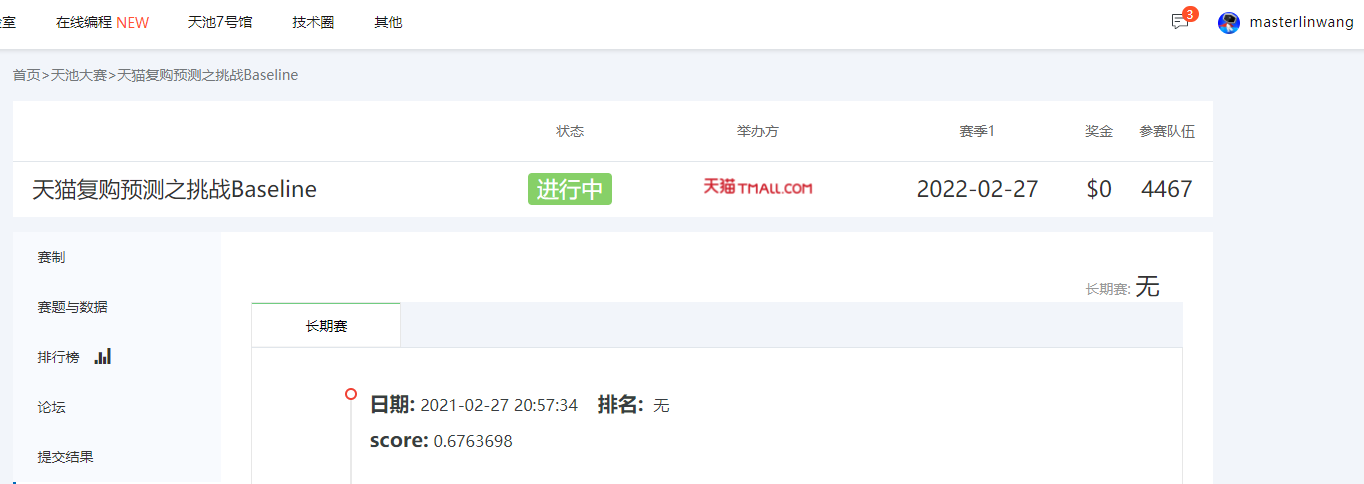